In [95]:
import numpy as np
import matplotlib.pyplot as plt
import copy

### creates Q and computes v_j, v_j'

In [3]:
def create_dict(ranking):
    idx_dict = {}
    n = len(ranking)
    for i in range(n):
        ky = ranking[i]
        idx_dict[ky] = i
    return idx_dict

In [18]:
# construct inversion matrix
def create_inversion_samelen(pi_, pi_0):
    #pi_0_idx = create_dict(pi_0)
    n = len(pi_)
    pi_idx = create_dict(pi_)
    #print(pi_idx)
    v_row = np.zeros(n)
    v_col = np.zeros(n)
    Q = np.zeros(shape=(n,n))
    
    # i,j ordering is corresponsing to pi_0
    for i in range(n):
        for j in range(n):
            # if pi_[j] < pi_i[i]:
            ky1 = pi_0[i] # row
            ky2 = pi_0[j] # col

            if ky2 in pi_idx and ky1 in pi_idx:
                #print("piky2: ", pi_idx[ky2])
                #print("piky1 :", pi_idx[ky1])
                if pi_idx[ky2] < pi_idx[ky1]: 
                    Q[i,j] = 1
                
                
    # only consider the lower triangle part           
    for i in range(n):
        for j in range(i):
            ky1 = pi_0[i] # row
            ky2 = pi_0[j] # col

            if ky2 in pi_idx and ky1 in pi_idx:
                #print("piky2: ", pi_idx[ky2])
                #print("piky1 :", pi_idx[ky1])
                if pi_idx[ky2] < pi_idx[ky1]: 
                    v_row[i] += 1
                    v_col[j] += 1
    return(Q, v_row, v_col)
    

In [14]:
# sample input of same length
#pi_0 = np.array(['a','b','c','d'])
#pi_ = np.array(['c', 'd', 'a', 'b'])

In [66]:
#create_inversion_samelen(pi_, pi_0)

### block detection

In [139]:
# array, float

def robust_mean(elems, frac):
    #print("elems: ", elems)
    v = np.sort(elems)
    n = len(elems)

    i1 = int(np.floor(n * frac))
    i2 = int(np.ceil(n * (1-frac)) - 1)
    #print("i1: ", i1)
    #print("i2: ", i2)
    v[:i1] = v[i1]
    v[i2:] = v[i2]
    #print("v: ", v)

    return np.mean(v), np.std(v)

In [135]:
def find_blocks(pi_2, pi_1, length_block, outlier_frac):
    n = len(pi_2)
    p = outlier_frac
    L = length_block
    inv_mat, v_row, v_col = create_inversion_samelen(pi_2, pi_1)
    
    row_mean = np.zeros(L)
    col_mean = np.zeros(L)
    row_sd = np.zeros(L)
    col_sd = np.zeros(L)
    
    for j in range(L, n, 1):
        #print(" v_row[(j-L + 1):j]: ", v_row[(j-L ):j])
        #print("v_col[(j-L + 1):j]: ", v_col[(j-L):j])
        row_mean_j, row_sd_j = robust_mean(v_row[(j-L ):j], p)
        col_mean_j, col_sd_j = robust_mean(v_col[(j-L):j], p)
        row_mean[j-L] = row_mean_j
        row_sd[j-L] = row_sd_j
        col_mean[j-L] = col_mean_j
        col_sd[j-L] = col_sd_j
    #print("L: ", L)
    #print("n: ", n)
    idx = np.arange(L,n, 1)
    #print("idx: ", idx)
    #print("v_row[L:n]: ", v_row[L:n])
    #print("row_mean: ", row_mean)
    #print("col_mean: ", col_mean)
    #print("row_sd: ", row_sd)
    #print("col_sd: ", col_sd)
    plt.plot(idx, v_row[L:n])
    plt.plot(idx, v_col[L:n])
    plt.errorbar(idx, row_mean, yerr=row_sd)
    plt.errorbar(idx, col_mean, yerr=col_sd)
 
    
    
    

### block completion

In [109]:
def find_intersect(pi1, pi2):
    pi_intersect = [value for value in pi1 if value in pi2]
    return pi_intersect

In [99]:
def adjust_bk(block, pi_1, pi_2): 
    
    for i in range(2):
        if i == 0:
            pi = pi_1
        else:
            pi = pi_2
        
        other_block = copy.deepcopy(block)
            
            
        
        check_membership = np.isin(pi, block)
        #print("check_membership: ", check_membership)
        n = len(pi)
        flag = 1

        min_ind = -1
        max_ind = -1
        for j in range(n):
            #print("j: ", j)
            if check_membership[j]:
                if flag:
                    min_ind = j
                    flag = 0
                max_ind = j
                
        # add to the other block if elem not in other block
        
        other_block = np.union1d(other_block, pi[min_ind:(max_ind+1)])
        
        if i == 0:
            B = other_block
        
        
    return (B, other_block)

In [51]:
def block_completion(pi_1, pi_2, length_block, p_outlier):
    intersection = find_intersect(pi_1, pi_2)
    pi_1_project = find_intersect(pi_1, intersection)
    pi_2_project = find_intersect(pi_2, intersection)
    all_blocks = find_blocks(pi_2_project, pi_1_project, length_block, p_outlier)
    completed_blocks = []
    for bk in all_blocks:
        completed_blocks.append(adjust_bk(bk, pi_1, pi_2))

### example 1 (on finding blocks)

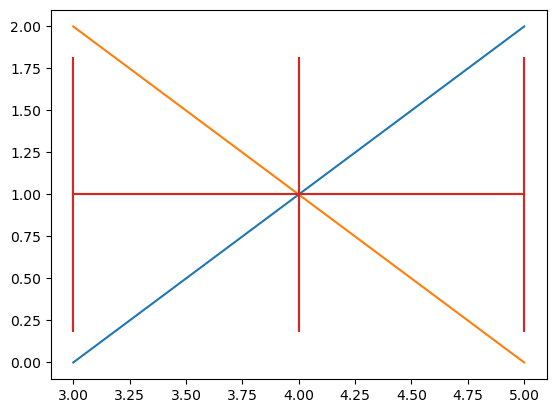

In [141]:
pi_1 = ['a', 'b', 'c', 'd', 'e', 'f']
pi_2 = ['d', 'e', 'f', 'a', 'b', 'c']
length_block = 3
p_outlier = 0.01
intersection = find_intersect(pi_1, pi_2)
#print("intersection: ", intersection)
pi_1_project = find_intersect(pi_1, intersection)
pi_2_project = find_intersect(pi_2, intersection)
all_blocks = find_blocks(pi_2_project, pi_1_project, length_block, p_outlier)
#all_blocks = find_blocks(pi_2, pi_1, length_block, p_outlier)

### example 2 (on finding B_0, B_0')

In [78]:
pi_1 = ['a', 'e', 'b', 'c', 'd']
pi_2 = ['c', 'd', 'f', 'a', 'b']

In [102]:
completed_blocks = []
for bk in all_blocks_:
    completed_blocks.append(adjust_bk(bk, pi_1, pi_2))

In [103]:
completed_blocks

[(array(['a', 'b', 'e'], dtype='<U1'), array(['a', 'b'], dtype='<U1')),
 (array(['c', 'd'], dtype='<U1'), array(['c', 'd'], dtype='<U1'))]